In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import copy
import pickle

data = loadmat('ex3data1.mat')


X = data['X']
Y = data['y']

for i in range(len(Y)):
    if Y[i][0] == 10:
        Y[i] = 0
    else:
        Y[i] = Y[i][0]

labels = []
for label in Y:
     labels.append(label[0])
        
X_sparse = coo_matrix(X)

X, X_sparse, labels = shuffle(X, X_sparse, labels, random_state=0)


for i in range(len(X)):
#     m = X[i].mean()
#     X[i] = X[i] - m
    x_min, x_max = X[i].min(), X[i].max()
    X[i] = (X[i]-x_min)/(x_max-x_min)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

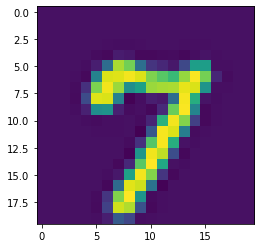

In [141]:
plt.imshow(X_train[6].reshape(1, 20, 20).transpose(0, 2, 1).reshape(20, 20))
plt.show()

In [142]:
# only for one example
class Linear:
    def __init__(self, input_dim, output_dim):
        self.w = np.random.randn(output_dim, input_dim)
        self.b = np.random.randn(output_dim, 1)
        self.x = None
        self.dw = None
        self.db = None
        
        self.type = 'linear'
        
    def forward(self, x):
        self.x = x
        
        out = np.dot(self.w, x) + self.b
        
        return out
    
    def backward(self, dout):
        self.dw = np.dot(dout, self.x.T)
        self.db = dout
        
        return np.dot(self.w.T, dout)

In [143]:
# only for one example
class ReLU:
    def __init__(self):
        self.mask = None
        
        self.type = 'relu'
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        
        dout[self.mask] = 0
        return dout

In [144]:
# only for one example
class softmax:
    def __init__(self):
        self.p = None
        self.t = None
    
    def forward(self, a, t):
        self.t = t
        c = np.max(a)
        exp_a = np.exp(a - c)
        sum_exp_a = np.sum(exp_a)
        p = exp_a / sum_exp_a
        
        self.p = p
        
        _p = np.log(p + 1e-5)

        loss = np.sum(-_p*t)
        
        return loss
    def backward(self):
        
        return self.p - self.t

In [145]:
# only for one example
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        '''
            kernel_size (h, w)
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.b = np.fabs(np.random.randn(self.out_channels, 1))
        self.w = np.fabs(np.random.randn(self.out_channels, self.in_channels, kernel_size[0], kernel_size[1]))

        self.dw = None
        self.db = None
        self.x = None
        
        self.type = 'conv2d'
        
    def forward(self, x):
        
        '''
            x numpy array of (1, h, w)
        '''
        
        if x.ndim == 2:
            x = x.reshape(-1, x.shape[0], x.shape[1])
       
        x = np.pad(x, ((0, 0), (self.padding, self.padding), (self.padding, self.padding)), 'constant', constant_values=0)
        
        _, in_h, in_w = x.shape
        
        out_h = 1 + int((in_h + 2*self.padding - self.kernel_size[0]) / self.stride)
        out_w = 1 + int((in_w + 2*self.padding - self.kernel_size[1]) / self.stride)
        
        _x = []
        for i in range(out_h):
            for j in range(out_w):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size[0]
                w_start = j * self.stride
                w_end = w_start + self.kernel_size[1]
                
                temp = x[:, h_start:h_end, w_start:w_end]

                _x.append(np.squeeze(np.reshape(temp, (1, 1, -1))))
        _x = np.array(_x)
        
        self.w = np.reshape(self.w, (self.out_channels, -1))
        self.x = _x.T
        
        out = np.dot(self.w, self.x)
        
        out += self.b
        
        out = out.reshape(self.out_channels, out_h, out_w)
        
        # this line
        self.db = np.zeros((self.out_channels, 1))
        
        return out
    
    def backward(self, dout):
        
        # this line
        dout = dout.reshape(-1, self.x.T.shape[0])
        
        self.dw = np.dot(dout, self.x.T)
        
#         for i in range(self.out_channels):
#             self.db[i, 0] += np.sum(dout[i])
        
        return np.dot(self.w.T, dout)

In [146]:
class MaxPool2d:
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride
        self.arg_max = None
        self.shape = None
        self.type = 'maxpool2d'
        
    def forward(self, x):
        
        in_channels, in_h, in_w = x.shape
        
        out_h = int(1 + (in_h - self.kernel_size[0]) / self.stride)
        out_w = int(1 + (in_w - self.kernel_size[1]) / self.stride)
        
        _x = []
        for i in range(in_channels): 
            for j in range(out_h):
                for k in range(out_w):
                    h_start = j * self.stride
                    h_end = h_start + self.kernel_size[0]
                    w_start = k * self.stride
                    w_end = w_start + self.kernel_size[1]
                
                    temp = x[i, h_start:h_end, w_start:w_end]

                    _x.append(np.squeeze(np.reshape(temp, (1, -1))))
        _x = np.array(_x)
        
        self.shape = x.shape
        
        out = np.max(_x, axis=1)
        
        self.arg_max = np.argmax(_x, axis=1)
        
        return out.reshape(in_channels, out_h, out_w)
    
    def backward(self, dout):
        dout = np.squeeze(dout.reshape(1, -1))
        
        _dout = np.zeros(self.shape)
        
        index = 0
        
        in_channels, in_h, in_w = self.shape
        
        out_h = int(1 + (in_h - self.kernel_size[0]) / self.stride)
        out_w = int(1 + (in_w - self.kernel_size[1]) / self.stride)
        
        for i in range(in_channels): 
            for j in range(out_h):
                for k in range(out_w):
                    h_start = j * self.stride
                    h_end = h_start + self.kernel_size[0]
                    w_start = k * self.stride
                    w_end = w_start + self.kernel_size[1]
                
                    p = h_start + int(self.arg_max[index] /  self.kernel_size[0])
                    q = w_start + self.arg_max[index] % self.kernel_size[1]
                    
                    _dout[i, p, q] = dout[index]
                    
                    index += 1
        
        return _dout

In [147]:
def MakeOneHot(class_num, x):
    true = np.zeros(class_num)
    true[x] = 1
    return true.reshape(class_num, -1)

In [148]:
model = []

model.append(Conv2d(1, 1, (2, 2)))
model.append(ReLU())
model.append(MaxPool2d((2, 2), 2))

model.append(Linear(81, 10))

model.append(softmax())

for layer in model:
    print(layer)

In [149]:
class CNN:
    def __init__(self, model):
        self.model = model
    
    def forward(self, x, y):

        for layer in self.model[0:-2]:
            
            x = layer.forward(x)
            
        x = x.reshape(-1, 1)
        x = model[-2].forward(x)
        
        x = model[-1].forward(x, y)
        return x
    
    def backward(self):
        dout = model[-1].backward()
        
        index = len(model) - 2
        while index >= 0:
            dout = model[index].backward(dout)
            index -= 1

In [150]:
net = CNN(model=model)

best_model = None
best_acc = -1

epochs = 30
lr = 0.1

for epoch in range(epochs):
    loss = 0
    for i in range(len(X_train)):

        loss += net.forward(X_train[i].reshape(1, 20, 20).transpose(0, 2, 1), MakeOneHot(10, y_train[i]))
        net.backward()
        
        # update parameters
        index = len(net.model) - 2
        while index >= 0:
            if net.model[index].type == 'linear' or net.model[index].type == 'conv2d':
                
                net.model[index].w -= lr * net.model[index].dw
                net.model[index].b -= lr * net.model[index].db
                
            index -= 1
        
    print("epoch: {}/{} loss: {}".format(epoch + 1, epochs, loss / len(X_train)))

    valid_correct = 0
    for i in range(len(X_valid)):
        net.forward(X_valid[i].reshape(1, 20, 20).transpose(0, 2, 1), MakeOneHot(10, y_valid[i]))
        
        if np.argmax(net.model[-1].p) == y_valid[i]:
            valid_correct += 1
    
    acc = valid_correct / len(X_valid)
    print("Valid Acc: {}".format(acc))
    if best_acc < acc:
        best_acc = acc
        best_model = copy.deepcopy(model)
        print("get new model!")

test_net = CNN(best_model)
test_correct = 0
for i in range(len(X_test)):
    test_net.forward(X_test[i].reshape(1, 20, 20).transpose(0, 2, 1), MakeOneHot(10, y_test[i]))

    if np.argmax(net.model[-1].p) == y_test[i]:
        test_correct += 1
print("Test Acc: {}".format(test_correct / len(X_test)))

epoch: 1/30 loss: 1.6781740804164966
Valid Acc: 0.675
get new model!
epoch: 2/30 loss: 0.7779262204779473
Valid Acc: 0.805
get new model!
epoch: 3/30 loss: 0.6135227806728563
Valid Acc: 0.82
get new model!
epoch: 4/30 loss: 0.5499390322208463
Valid Acc: 0.83375
get new model!
epoch: 5/30 loss: 0.51365645131551
Valid Acc: 0.83
epoch: 6/30 loss: 0.4890355906728884
Valid Acc: 0.83625
get new model!
epoch: 7/30 loss: 0.4723103067332009
Valid Acc: 0.835
epoch: 8/30 loss: 0.4657184004472175
Valid Acc: 0.84
get new model!
epoch: 9/30 loss: 0.4570881241361976
Valid Acc: 0.84
epoch: 10/30 loss: 0.44954247917315754
Valid Acc: 0.83875
epoch: 11/30 loss: 0.4444877339648597
Valid Acc: 0.845
get new model!
epoch: 12/30 loss: 0.4292646813867209
Valid Acc: 0.84875
get new model!
epoch: 13/30 loss: 0.42680298906174136
Valid Acc: 0.84875
epoch: 14/30 loss: 0.4229125257677282
Valid Acc: 0.84875
epoch: 15/30 loss: 0.41870543620022554
Valid Acc: 0.85125
get new model!
epoch: 16/30 loss: 0.4887472816133107
